# Notebook to show how we computed PPH and SigSVR in Canada with the LSR data there and to show how we selected our cases and the areas for them  

In [1]:
# install metpy version 1.6.3 for this notebook only
!uv pip install metpy==1.6.3

Using Python 3.13.2 environment at: ExtremeWeatherBench/.venv
Audited 1 package in 72ms


In [10]:
# all the imports you should need for this notebook
import xarray as xr
import metpy
import numpy as np
import pandas as pd
# Add colorbar with same height as plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import requests
from typing import Optional, Union, Literal
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import requests
import matplotlib.colors as mcolors
import matplotlib.patches as patches

# added by amy
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from matplotlib.lines import Line2D
import shapely
from shapely.geometry import Polygon

import pandas as pd
from datetime import datetime, timedelta

from pathlib import Path

# make the basepath - change this to your local path
basepath = Path.home() / 'ExtremeWeatherBench' / ''
basepath = str(basepath) + '/'

# ugly hack to load in our plotting scripts
import sys
sys.path.append(basepath + "/docs/notebooks/")
import derived as derived
from extremeweatherbench import inputs

# Functions to read in and plot the data in Canada

In [2]:
# This is modified from the original code for CONUS to work with Canada LSR data
def extract_lsr_data_canada(date: pd.Timestamp) -> pd.DataFrame:
    """Pull the latest LSR data for a given date. We pull all reorts within 1 day. If date is none, we return all reports
    
    Args:
        date: A pandas Timestamp object.
    Returns:
        df: A pandas DataFrame containing the LSR data with columns lat, lon, report_type, time, and scale.
    """

    datafile = '/home/amy/CanadaLSRData_2020-2024.csv'

    # Read the CSV files with all columns to identify report types
    try:
        df = pd.read_csv(datafile, delimiter=',', engine='python', parse_dates=['Date/Time UTC'], date_format='%Y-%m-%d %H:%M:%S')
    except Exception as e:
        print(f'Error pulling hail data for {date}: {e}')
        return pd.DataFrame()

    # if date is none, presumably we want all reports
    if (date == None):
        return df

    # Filter the DataFrame for the specified date range
    spc_date = pd.Timestamp(date.year, date.month, date.day, 12, 00)  # Normalize to noon
    start_date = spc_date    
    end_date = spc_date + pd.Timedelta(days=1.0)
    df = df[(df['Date/Time UTC'] >= start_date) & (df['Date/Time UTC'] < end_date)]
    if len(df) == 0:
        #print(f'No LSR data found for {start_date} to {end_date}')
        return pd.DataFrame()
    return df


In [11]:
# helper functions to make the main plotting function cleaner
# helper function to convert a bounding box tuple to a shapely Polygon
def get_polygon_from_bounding_box(bounding_box):
    """Convert a bounding box tuple to a shapely Polygon."""
    if bounding_box is None:
        return None
    left_lon, right_lon, bot_lat, top_lat = bounding_box
    return Polygon(
        [
            (left_lon, bot_lat),
            (right_lon, bot_lat),
            (right_lon, top_lat),
            (left_lon, top_lat),
            (left_lon, bot_lat),
        ]
    )

# helper function to plot a polygon on a cartopy axis
def plot_polygon_outline(polygon, ax, color='yellow', alpha=0.5):
    """Plot a shapely Polygon on a Cartopy axis."""
    if polygon is None:
        return
    patch = patches.Polygon(
        polygon.exterior.coords,
        closed=True,
        facecolor='none',
        edgecolor=color,
        alpha=alpha,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(patch)


# imported from figure 1 notebook and adjusted to plot reports
def plot_local_cases(left_lon, right_lon, bot_lat, top_lat, df, filename, plot_title, pph=None, sigsvr=None):
    """Plot the specified cases on a map of Canada.
    Args:
        left_lon: The left longitude of the bounding box.
        right_lon: The right longitude of the bounding box.
        bot_lat: The bottom latitude of the bounding box.
        top_lat: The top latitude of the bounding box.
        df: A pandas DataFrame containing the LSR data with columns 'Longitude', 'Latitude', and 'report_type'.
        filename: The name of the file to save the plot.
        plot_title: The title of the plot.
        pph: A 2D array of probabilities for plotting (optional).
        sigsvr: A 2D array of SIGSVR values for plotting (optional).
    Returns:
        None: The function saves the plot to the specified filename.
    """
    fig = plt.figure(figsize=(15, 10))
    #ax = plt.axes(projection=ccrs.LambertConformal())
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines and gridlines
    ax.coastlines(zorder=10)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', zorder=9)
    ax.add_feature(cfeature.STATES, edgecolor='grey', zorder=5)
    ax.add_feature(cfeature.LAND, edgecolor='black', zorder=3)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white', zorder=2)
    # plot the states
    #ax.add_feature(cfeature.OCEAN, zorder=10)
    #utils.remove_ocean_gridpoints(sigsvr)
    my_box = [left_lon, right_lon, bot_lat, top_lat]
    ax.set_extent(my_box, crs=ccrs.PlateCarree())

    # Add gridlines
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    if (pph is not None):
        # Plot the data using contourf
        levels = [0.01, .05,.15,.30,.45,.60,.75] 

        # Create a custom colormap that sets alpha=0 for values below 0.05
        cmap = plt.cm.viridis
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Create the colormap with alpha=0 for values below 0.05
        # Create a mask for values below 0.05
        mask = np.ma.masked_less(pph, 0.01)
        cmap_with_alpha = plt.cm.viridis.copy()
        cmap_with_alpha.set_bad('none', alpha=0)  # Set masked values to transparent

        contour = ax.contour(pph.longitude, pph.latitude, mask, 
                            levels=levels, transform=ccrs.PlateCarree(),
                            cmap=cmap_with_alpha, norm=norm, extend='both', zorder=15)

        # Add colorbar
        cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8, spacing='proportional')
        cbar.lines[0].set_linewidth(10.0)
        cbar.set_label('Probability')

    if (sigsvr is not None):
        masked_sigsvr = sigsvr.where(sigsvr >= 500)
        print(masked_sigsvr.max())
        im = masked_sigsvr.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds',
                        add_colorbar=False, vmin=0)
        cbar = fig.colorbar(im, label="Craven SigSvr (m³/s³)")
        cbar.set_label("Craven SigSvr (m³/s³)", size=14)
        cbar.ax.tick_params(labelsize=12)

    # Make sure reports are visible by increasing size and using a distinctive color
    # Convert string coordinates to float before plotting
    colors = {'tor': 'red','wind': 'blue', 'hail': 'black'}
    markers= {'tor': 'o', 'wind': 's', 'hail': '^'}  

    event_colors = {'non_tornadic_vortex': 'pink', 'unclassified_wind_damage': 'blue', 
                    'tornado_over_land': 'red', 'downburst': 'darkblue', 'tornado_over_water': 'lightcoral', 
                    'unclassified_visual_vortex': 'orange', 'nan': 'gray'}

    # Define zorder values to control plotting order (higher values appear on top)
    zorders = {'tor': 22, 'wind': 21, 'hail': 20}
    
    # Sort the dataframe by report type to ensure tornadoes are plotted last (on top)
    # Create a custom sort order where 'tor' comes last
    sort_order = {'hail': 0, 'wind': 1, 'tor': 2}
    sorted_df = df.copy()
    sorted_df['sort_key'] = sorted_df['report_type'].map(sort_order)
    
    # Group by report type and plot each group with its own color
    for report_type, group in sorted_df.sort_values('sort_key').groupby('report_type'):
        ax.scatter(group['Longitude'].astype(float), group['Latitude'].astype(float), 
                  color=colors.get(report_type, 'gray'), s=20, marker=markers.get(report_type), alpha=0.9,
                  transform=ccrs.PlateCarree(), label=f'{report_type.capitalize()} Reports', 
                  zorder=zorders.get(report_type, 10))

    # Count the number of reports for each type
    counts = df['report_type'].value_counts().to_dict()
    print(counts)

    # Create custom legend handles
    legend_elements = [
        Line2D([0], [0], marker=markers.get(label), color=colors[label], label=f'{label} (n={count})', markerfacecolor=colors[label], markersize=10)
        for label, count in counts.items()
    ]
    
    
     # Create a larger legend by specifying a larger font size in the prop dictionary
    ax.legend(handles=legend_elements, loc='upper left', framealpha=1, frameon=True, borderpad=0.5, handletextpad=0.8, handlelength=2.5)
    ax.set_title("")
    ax.set_title(plot_title, loc='left', fontsize=20)

    if (filename is not None):
        plt.savefig(filename, transparent=False, bbox_inches='tight', dpi=300)

{'hail': 886, 'tor': 490}


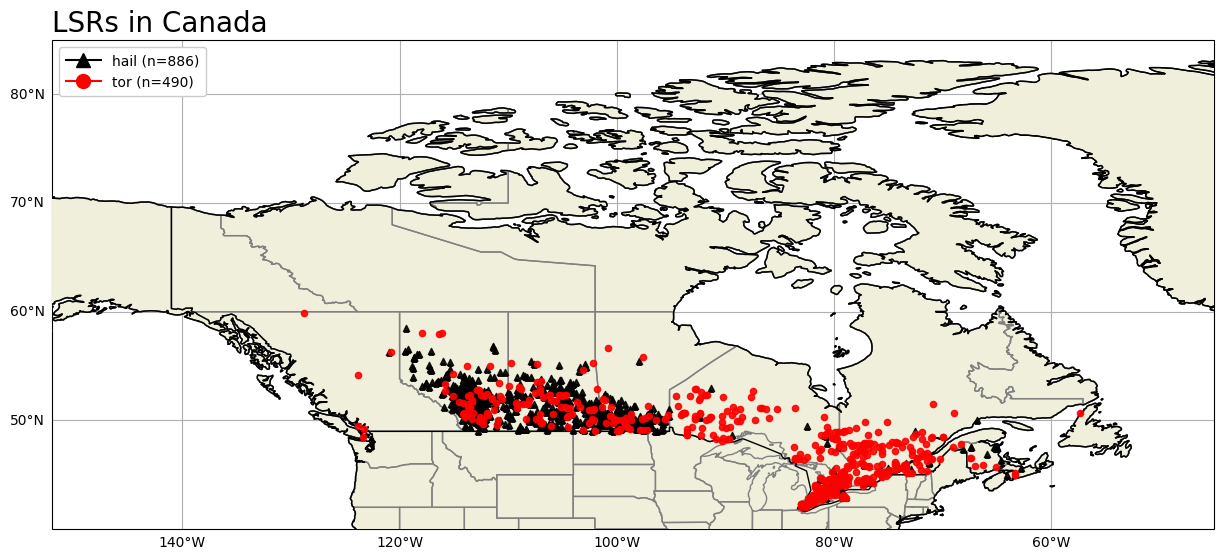

In [5]:
# quick test of all points in Canada
# plot North America
bot_lat = 40
top_lat = 85
left_lon = -152
right_lon = -45

bounding_box = [left_lon, right_lon, bot_lat, top_lat]
plot_title = 'LSRs in Canada'

can_data = extract_lsr_data_canada(date=None)  # Get all reports
#print(can_data)

# set filename to the file if you want to actually save it
plot_local_cases(left_lon, right_lon, bot_lat, top_lat, can_data, filename=basepath + 'docs/notebooks/figs/LSR_Canada.png', plot_title=plot_title)
    

In [8]:
def practically_perfect_hindcast_weighted(
    df = None,
    resolution: float = 0.25,
    report_type: Union[Literal["all"], list[Literal["tor", "hail", "wind"]]] = "all",
    sigma: float = 1.5,
    return_reports: bool = False,
    output_resolution: Optional[float] = None,
    report_constants = {'hail': 1, 'tor': 1}
) -> Union[xr.DataArray, tuple[xr.DataArray, pd.DataFrame]]:
    """Compute the Practically Perfect Hindcast (PPH) using storm report data using latitude/longitude grid spacing
    instead of the NCEP 212 Eta Lambert Conformal projection; based on the method described in Hitchens et al 2013,
    https://doi.org/10.1175/WAF-D-12-00113.1

    Args:
        date: A pandas Timestamp object.
        resolution: The resolution of the grid to use. Default is 0.25 degrees.
        report_type: The type of report to use. Default is all. Currently only supports all.
        sigma: The sigma (standard deviation) of the gaussian filter to use. Default is 1.5.
        return_reports: Whether to return the reports used to compute the PPH. Default is False.
        output_resolution: The resolution of the output grid. Default is None (keep the same resolution as the input grid).
        report_constants: A dictionary mapping report types to their respective values for the PPH grid. Default is {'hail': 15, 'tor': 5}.
    Returns:
        pph: An xarray DataArray containing the PPH around the storm report data.
    """

    #df = extract_lsr_data_canada(date)
    if report_type == "all":
        pass
    else:
        df = df[df['report_type'].isin(report_type)]

    # Create a grid covering Canada
    lat_min, lat_max = 10, 85   
    lon_min, lon_max = -152, -45  

    # Create the grid coordinates
    grid_lats = np.arange(lat_min, lat_max + resolution, resolution)
    grid_lons = np.arange(lon_min, lon_max + resolution, resolution)

    # Initialize an empty grid
    grid = np.zeros((len(grid_lats), len(grid_lons)))

    # extract reports for TOR and HAIL separately to handle the underreporting
    for report_type in report_constants.keys():
        # Filter the dataframe for the current report type
        df2 = df[df['report_type'] == report_type]

        # Extract latitude and longitude from the dataframe
        lats = df2["Latitude"].astype(float)
        lons = df2["Longitude"].astype(float)

        # Mark grid cells that contain reports
        for lat, lon in zip(lats, lons):
            # Find the nearest grid indices
            lat_idx = np.abs(grid_lats - lat).argmin()
            lon_idx = np.abs(grid_lons - lon).argmin()
            grid[lat_idx, lon_idx] = report_constants[report_type]  # Set a value to indicate a report is present

    # Create the xarray DataArray
    pph = xr.DataArray(
        grid,
        dims=["latitude", "longitude"],
        coords={"latitude": grid_lats, "longitude": grid_lons},
        name="practically_perfect",
    )

    # Apply bilinear interpolation to smooth the field
    # First, create a gaussian kernel for smoothing
    smoothed_grid = gaussian_filter(grid, sigma=sigma)

    # Replace the data in the DataArray
    pph.data = smoothed_grid
    if output_resolution is not None:
        pph = pph.interp(latitude=np.arange(lat_min, lat_max + output_resolution, output_resolution),
                        longitude=np.arange(lon_min, lon_max + output_resolution, output_resolution),method='linear')
    if return_reports:
        return (pph, df)
    return pph

{'tor': 13, 'hail': 1}


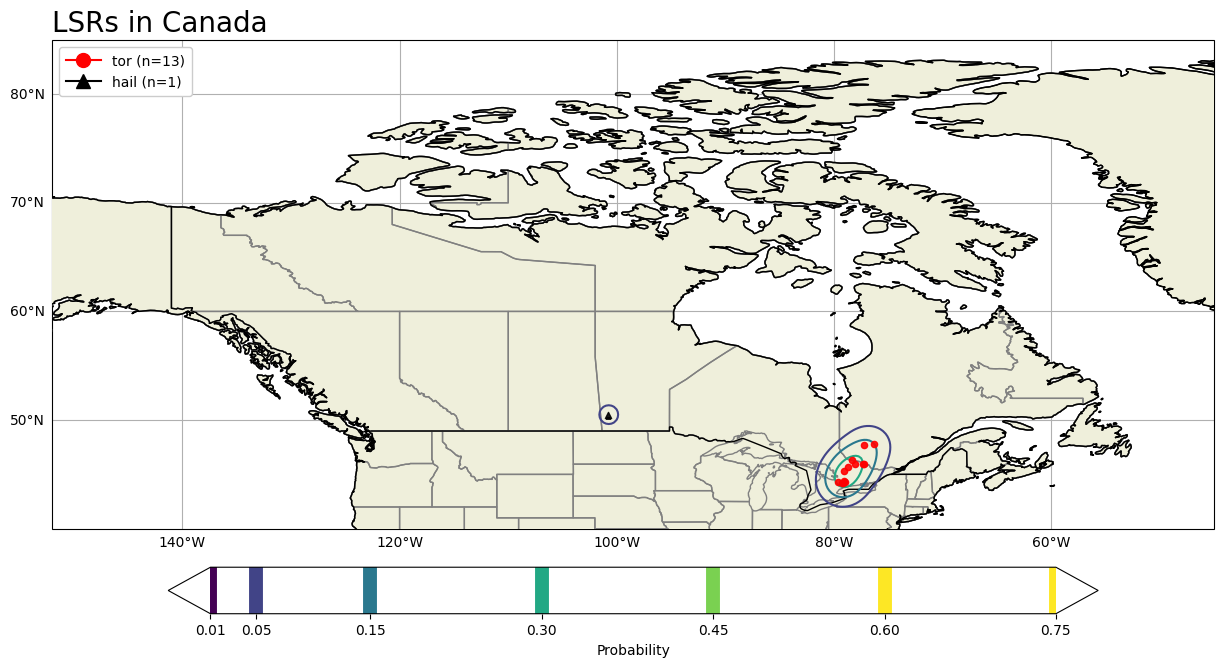

In [7]:
# plot a specific test case with PPH to verify that it is working well with the chosen weights
date = pd.Timestamp(2021,7,15,12,00)
daily_data = extract_lsr_data_canada(date=date)  # Get all reports

pph = practically_perfect_hindcast_weighted(daily_data, sigma=5, report_constants={'tor': 10, 'hail': 10})

#print(daily_data)
    
# plot PPH and the cases
plot_local_cases(left_lon, right_lon, bot_lat, top_lat, daily_data, None, plot_title, pph=pph)

#print(pph)
#pph.plot()

In [ ]:
# loop through all dates from 2020-2024
for date in pd.date_range('2020-01-01', '2024-12-31'):
     # Filter the DataFrame for the specified date range
    daily_data = extract_lsr_data_canada(date=date)  # Get all reports    

    if len(daily_data) >= 10:
        # Count the number of reports for each type
        counts = daily_data['report_type'].value_counts().to_dict()
        # make sure there is a tor count greater than 0
        # if there is, plot the PPH and the cases
        if (counts.get('tor', 0) > 0):
            print(f"{date.strftime('%Y-%m-%d')}: {len(daily_data)} reports - {counts}")

            filename = basepath + f"docs/notebooks/figs/Canada_LSR_{date.strftime('%Y-%m-%d')}.png"
            plot_title = f"LSRs focused on Canada for {date.strftime('%Y-%m-%d')} 12Z to {(date + pd.Timedelta(days=1.0)).strftime('%Y-%m-%d %H:%M')} 12Z"

            # compute PPH on this date
            pph = practically_perfect_hindcast_weighted(daily_data, sigma=5, report_constants={'tor': 10, 'hail': 10})

            # plot PPH and the cases
            plot_local_cases(left_lon, right_lon, bot_lat, top_lat, daily_data, filename, plot_title, pph=pph)
            #plt.close()

        

# Load in the US data so we can compare across the border

In [4]:
def pull_lsr_data(date: pd.Timestamp) -> pd.DataFrame:
    """Pull the latest LSR data for a given date. A "date" for LSRs is considered the
    date starting at 12 UTC to the next day at 11:59 UTC.
    
    Args:
        date: A pandas Timestamp object.
    Returns:
        df: A pandas DataFrame containing the LSR data with columns lat, lon, report_type, time, and scale.
    """
    # Try the filtered URL first, if it fails, try without _filtered
    url = f"https://www.spc.noaa.gov/climo/reports/{date.strftime('%y%m%d')}_rpts_filtered.csv"
    # Check if the URL exists by attempting to open it
    response = requests.head(url)
    if date < pd.Timestamp('2004-02-29'):
        raise ValueError("LSR data before 2004-02-29 is not available in CSV format")
    if response.status_code == 404:
        # If the filtered URL doesn't exist, use the non-filtered version
        url = f"https://www.spc.noaa.gov/climo/reports/{date.strftime('%y%m%d')}_rpts.csv"
    # Read the CSV file with all columns to identify report types
    try:
        df = pd.read_csv(url, delimiter=',', engine='python', names=['Time','Scale','Location','County','State','Lat','Lon','Comments'])
    except Exception as e:
        print(f'Error pulling LSR data for {date}: {e}')
        return pd.DataFrame()
    if len(df) == 3:
        return pd.DataFrame()
    # Initialize report_type column
    df['report_type'] = None
    
    # Find rows with headers and mark subsequent rows with appropriate report type
    for i, row in df.iterrows():
        if 'F_Scale' in row.values:
            df.loc[i+1:, 'report_type'] = 'tor'
        elif 'Speed' in row.values:
            df.loc[i+1:, 'report_type'] = 'wind'
        elif 'Size' in row.values:
            df.loc[i+1:, 'report_type'] = 'hail'
    
    # Keep only necessary columns
    df = df[['Lat', 'Lon', 'report_type','Time', "Scale"]]
    # Remove rows that have 'Lat' in the 'Lat' column (these are header rows)
    df = df[df['Lat'] != 'Lat']
    time = pd.to_datetime(df['Time'], format='%H%M').dt.time
    df['Time'] = pd.to_datetime(date.strftime('%Y-%m-%d') + ' ' + time.astype(str))
    df = df.rename(columns={'Lat': 'lat', 'Lon': 'lon','Time':'time'})
    return df

In [8]:
from extremeweatherbench import evaluate, utils, cases, defaults

# load in all of the events in the yaml file
case_dict = utils.load_events_yaml()

# turn the dictionary into a list of case objects
ewb_cases = cases.load_individual_cases(case_dict)

# build out all of the expected data to evalate the case
# this will not be a 1-1 mapping with ewb_cases because there are multiple data sources to evaluate for some cases
# for example, a heat/cold case will have both a case operator for ERA-5 data and GHCN
case_operators = cases.build_case_operators(case_dict, defaults.get_brightband_evaluation_objects())

This function is deprecated and will be removed in a future release. Please use cases.load_ewb_events_yaml_into_case_collection instead.
This function is deprecated and will be removed in a future release. Please use cases.read_incoming_yaml instead.


In [9]:
# helper function to convert a bounding box tuple to a shapely Polygon
def get_polygon_from_bounding_box(bounding_box):
    """Convert a bounding box tuple to a shapely Polygon."""
    if bounding_box is None:
        return None
    left_lon, right_lon, bot_lat, top_lat = bounding_box
    return Polygon(
        [
            (left_lon, bot_lat),
            (right_lon, bot_lat),
            (right_lon, top_lat),
            (left_lon, top_lat),
            (left_lon, bot_lat),
        ]
    )

In [ ]:
# now loop through the cases in the US and plot the data from Canada for the US dates on a North America map
# plot North America
bot_lat = 20
top_lat = 85
left_lon = -152
right_lon = -45

bounding_box = [left_lon, right_lon, bot_lat, top_lat]
plot_title = 'LSRs in Canada and the US'
 # save the bounding box polygon to subset the counts later
bounding_box_polygon = get_polygon_from_bounding_box(bounding_box)

for indiv_case in ewb_cases.cases:
    indiv_event_type = indiv_case.event_type
    # only look at the severe events
    if (indiv_event_type != 'severe_convection'):
        continue

    # check if the case is inside the bounding box
    if bounding_box is not None:
        if (not shapely.intersects(indiv_case.location.geopandas.geometry[0], bounding_box_polygon)):
            print(f"Skipping case {indiv_case.case_id_number} as it is outside the bounding box.")
            continue

    date = indiv_case.start_date
    print(f"Processing case {indiv_case.case_id_number} on {date.strftime('%Y-%m-%d')}")

    can_data = extract_lsr_data_canada(date)
    #print(can_data)
    us_data = pull_lsr_data(date)
    us_data.rename(columns={'lat': 'Latitude', 'lon': 'Longitude'}, inplace=True)
    #print(us_data)
    # drop all the wind reports to focus on hail and tor
    us_data = us_data[us_data['report_type'] != 'wind']

    joint_data = pd.concat([can_data, us_data], ignore_index=True)

    # set filename to the file if you want to actually save it
    filename = basepath + f"docs/notebooks/figs/Canada_US_LSR_{date.strftime('%Y-%m-%d')}.png"
    plot_title = f"LSRs in Canada and the US using US dates for {date.strftime('%Y-%m-%d')} 12Z to {(date + pd.Timedelta(days=1.0)).strftime('%Y-%m-%d %H:%M')} 12Z"

    pph = practically_perfect_hindcast_weighted(joint_data, sigma=5, report_constants={'tor': 10, 'hail':10})

    plot_local_cases(left_lon, right_lon, bot_lat, top_lat, joint_data, filename=filename, plot_title=plot_title, pph=pph)
    

In [ ]:
# plot North America
bot_lat = 10
top_lat = 85
left_lon = -152
right_lon = -45

bounding_box = [left_lon, right_lon, bot_lat, top_lat]

# do the opposite and look for Canadian event days and then plot the US data with it
# look through every date in the australia data print the case count for all non-zero dates
can_data = extract_lsr_data_canada(date=None)  # Get all reports

# loop through all dates from 2020-2024
for date in pd.date_range('2020-01-01', '2024-12-31'):
    # grab the canada data for this date
    daily_data = extract_lsr_data_canada(date=date)  # Get all reports

    if len(daily_data) >= 10:
        # Count the number of reports for each type
        counts = daily_data['report_type'].value_counts().to_dict()
        # make sure there is a tor count greater than 0
        # if there is, plot the PPH and the cases
        if (counts.get('tor', 0) > 0):
            print(f"{date.strftime('%Y-%m-%d')}: {len(daily_data)} reports - {counts}")

            filename = basepath + f"docs/notebooks/figs/Canada_LSR_{date.strftime('%Y-%m-%d')}.png"
            plot_title = f"LSRs in Canada for {date.strftime('%Y-%m-%d')}"

            us_data = pull_lsr_data(date)
            us_data.rename(columns={'lat': 'Latitude', 'lon': 'Longitude'}, inplace=True)
            #print(us_data)
            # drop all the wind reports to focus on hail and tor
            if (us_data is not None) and (len(us_data) > 0):
                us_data = us_data[us_data['report_type'] != 'wind']

            joint_data = pd.concat([daily_data, us_data], ignore_index=True)

            # set filename to the file if you want to actually save it
            filename = basepath + f"docs/notebooks/figs/Canada_US_LSR_{date.strftime('%Y-%m-%d')}.png"
            plot_title = f"LSRs in Canada and US using Canada events for {date.strftime('%Y-%m-%d')} 12Z to {(date + pd.Timedelta(days=1.0)).strftime('%Y-%m-%d %H:%M')} 12Z"

            pph = practically_perfect_hindcast_weighted(joint_data, sigma=5, report_constants={'tor': 10, 'hail':10})

            plot_local_cases(left_lon, right_lon, bot_lat, top_lat, joint_data, filename=filename, plot_title=plot_title, pph=pph)



{'hail': 24, 'tor': 10}


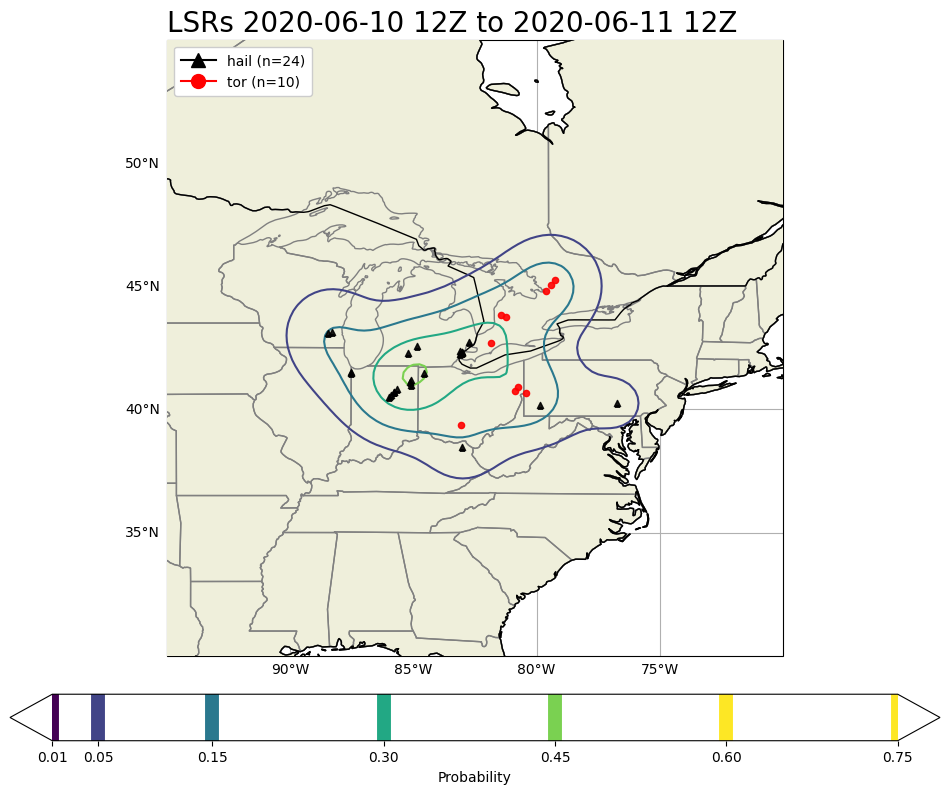

In [29]:
# plot North America
bot_lat = 30
top_lat = 55
left_lon = -95
right_lon = -70
    
# plot a specific test case with PPH to verify that it is working well with the chosen weights
date = pd.Timestamp(2020,6,10,00,00)
daily_data = extract_lsr_data_canada(date=date)  # Get all reports

us_data = pull_lsr_data(date)
us_data.rename(columns={'lat': 'Latitude', 'lon': 'Longitude'}, inplace=True)
#print(us_data)
# drop all the wind reports to focus on hail and tor
if (us_data is not None) and (len(us_data) > 0):
    us_data = us_data[us_data['report_type'] != 'wind']

joint_data = pd.concat([daily_data, us_data], ignore_index=True)

# set filename to the file if you want to actually save it
filename = basepath + f"docs/notebooks/figs/Canada_US_LSR_{date.strftime('%Y-%m-%d')}.png"
#plot_title = f"LSRs in Canada and US using Canada events for {date.strftime('%Y-%m-%d')} 12Z to {(date + pd.Timedelta(days=1.0)).strftime('%Y-%m-%d %H:%M')} 12Z"
plot_title = "LSRs 2020-06-10 12Z to 2020-06-11 12Z"

pph = practically_perfect_hindcast_weighted(joint_data, sigma=5, report_constants={'tor': 10, 'hail':10})

plot_local_cases(left_lon, right_lon, bot_lat, top_lat, joint_data, filename=None, plot_title=plot_title, pph=pph)

